In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#import os
#from distutils.dir_util import copy_tree
#from xlrd import open_workbook
#from xlutils.copy import copy
#import json

In [11]:
def setup(flag):
#ugly code straight from the script
    runs=30
    rng = [0.8,1.2]
    ndist=50000

    rawdat={}
    lcs={}
    samples={}
#varnames=['pwsi','soeci','pemeci','sofci','pemfci','ccsgi','ccsci','pwsemi','soecemi','pwseff']
#varbounds={} add to code when cleaning up

    pwsefflb=0.49875
    pwseffub=0.5775

#pwsemilb=0.456
    pwsemilb=0.2
    pwsemiub=5.405

    soecemilb=0.2
    soecemiub=5.405

    rawdat['pwsi']=3088.0
    rawdat['pwseff']=0.525
    rawdat['pwsemi']=1.08
    rawdat['soeci']=1388
    rawdat['soecemi']=1.08
    rawdat['pemeci']=3800
    rawdat['pemfci']=7339    
    rawdat['sofci']=7339
    rawdat['ccsgi']=2626.0
    rawdat['ccsci']=5252.0

    lcs['pwsi']=[1001.15/3088,(1001.15/3088)]
    lcs['pwsemi']=[0.72/1.08,(0.72/1.08)]
    lcs['soeci']=[450.0/1388,(450.0/1388)]
    lcs['soecemi']=[0.72/1.08,(0.72/1.08)]
    lcs['pemeci']=[1500/3800.0,400.0/3800.0,(400.0/3800.0)]
    lcs['pemfci']=[4000.0/7339,3000.0/7339,(3000.0/7339)]
    lcs['sofci']=[4000.0/7339,3000.0/7339,(3000.0/7339)]
    lcs['ccsgi']=[1422/2626.0,(1422/2626.0)]
    lcs['ccsci']=[4091/5252.0,(4091/5252.0)]       

    for key in rawdat:
        mean=rawdat[key]
        if key=='pwseff':
            l1=pwsefflb
            l2=pwseffub
            dist=np.sort(np.random.triangular(l1,mean,l2,size=ndist))
        elif key=='pwsemi':
            l1=pwsemilb
            l2=pwsemiub
            dist=np.sort(np.random.triangular(l1,mean,l2,size=ndist))
        elif key=='soecemi':
            l1=soecemilb
            l2=soecemiub
            dist=np.sort(np.random.triangular(l1,mean,l2,size=ndist))
        else:
            l1=rng[0]*mean
            l2=rng[1]*mean
            sigma=np.std([l1,mean,l2])/3.3
            #random.seed()
            dist=np.sort(np.random.normal(loc=mean, scale=sigma, size=ndist))
            for j in range(len(dist)):
                if dist[j]<l1 or dist[j]>l2:
                    dist[j]=0
            dist=np.trim_zeros(dist)
            #print(len(dist))
        dlen=len(dist)
        medloc=0
        for k in range(dlen):
            if dist[k]>mean:
                medloc=k
                break
        idx1=random.sample(range(medloc), int(runs/2))
        idx2=random.sample(range(medloc+1,dlen), int(runs/2))
        idx=idx1+idx2
        if flag==1:
            random.shuffle(idx)
        slst=[]
        for i in range(len(idx)):
            slst.append(dist[idx[i]])
        samples[key]=slst
    return samples

def analyze(nruns,flag):
    
    '''
generates samples for sensitivity analysis "nruns" times
normalizes samples between 0 to 1
sorts samples into bins 0.0-0.1,0.1-0.2,...,0.9-1.0 to check randomness
also calculates successive samples' difference's norm to make sure identical samples aren't being generated
returns count in bins dict(bins), and the difference in norms for each sensitivity analysis variable
    '''
    bins={}
    diffnorms={}
    normsamp1={}
    normsamp2={}
    
    #just to initialize the dicts:
    sample=setup(flag)
    for key in sample:
        bins[key]=np.zeros(len(sample[key]))
        diffnorms[key]=[]
        smin=min(sample[key])
        smax=max(sample[key])
        #normalize and store samples
        normsamp1[key]=np.asarray([(x-smin) /(smax-smin) for x in sample[key]])
        normsamp2[key]=normsamp1[key]
    
    #main test
    for k in range(nruns):
        sample=setup(flag)
        for key in sample:
            smin=min(sample[key])
            smax=max(sample[key])
            normsamp2[key]=np.asarray([(x-smin) /(smax-smin) for x in sample[key]])
            normsamp2[key]=np.asarray(normsamp2[key])
            diffnorms[key].append(np.linalg.norm(normsamp2[key]-normsamp1[key]))
            normsamp1[key]=normsamp2[key]
            for i in range(len(bins[key])):
                bins[key][i]+=normsamp2[key][i]                
    return bins,diffnorms

def plotsamples(binlist,difflist,key):
    labels = []
    for i in range(len(binlist)):
        labels.append(str(i+1))
    fig,ax=plt.subplots()
    width=0.1
    x=np.arange(len(labels))
    ax.bar(x,binlist,width,label=key)
    ax.set_ylabel('Tallies')
    ax.set_title('Counts of normalized samples')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Bins')
    ax.legend()
    
    fig1,ax1=plt.subplots()
    ax1.scatter(range(1,len(difflist)+1),difflist)
    ax1.set_title('Norms of difference of successive samples')
    


In [13]:
testruns=50 #note that each run generates 30 samples of 10 variables, i.e. testruns*300 samples
flag=1 #flag =1 implements in the correction command i.e. random.shuffle(idx)
cbins={}
diffnorm={}
cbins,diffnorm=analyze(testruns,flag)


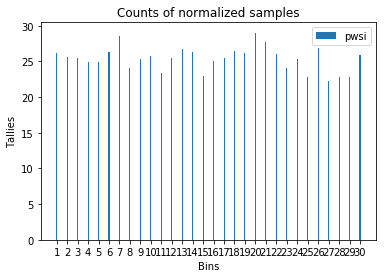

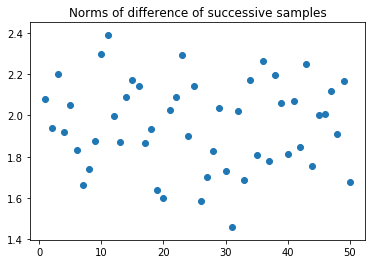

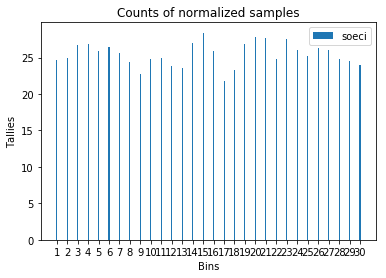

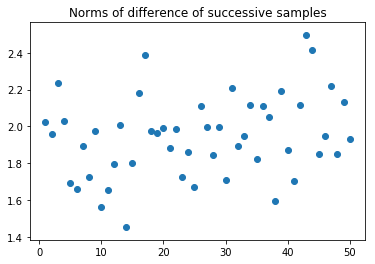

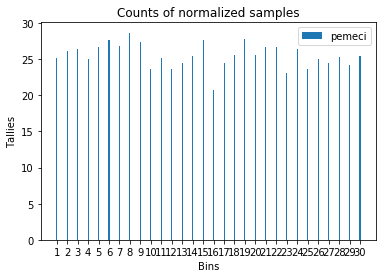

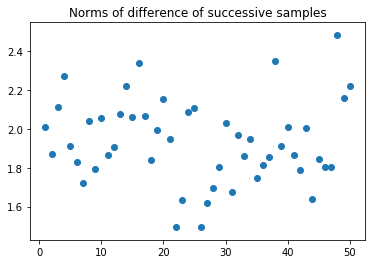

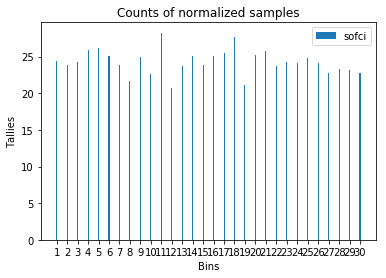

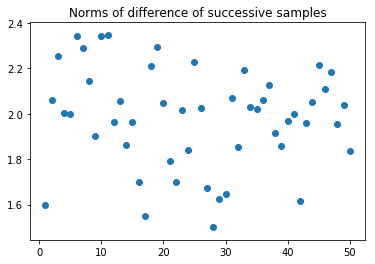

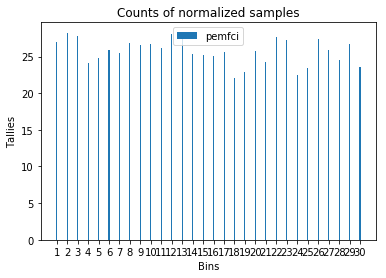

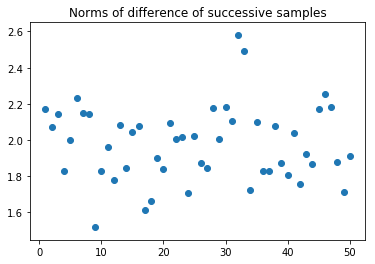

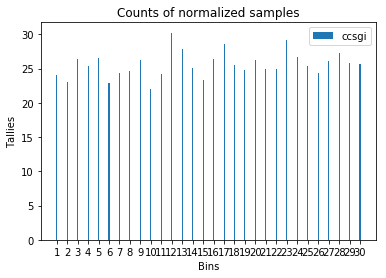

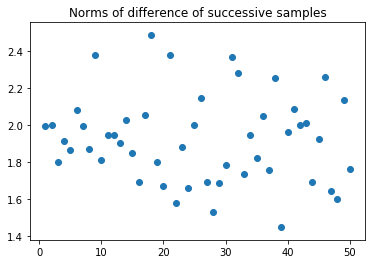

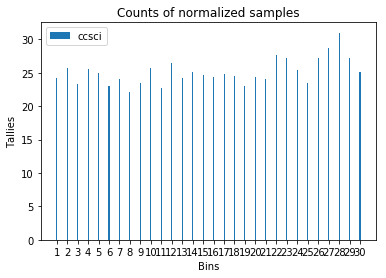

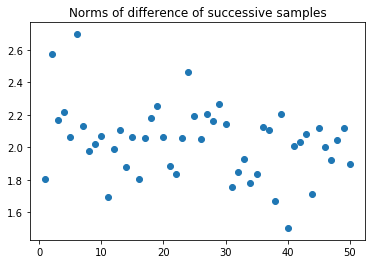

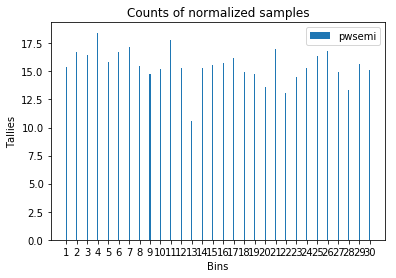

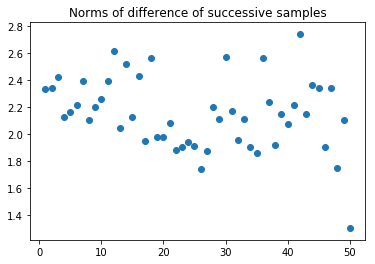

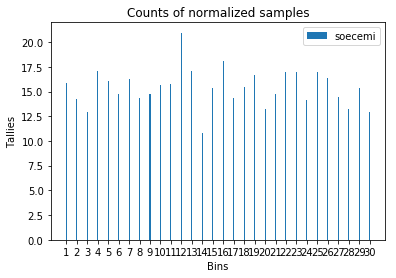

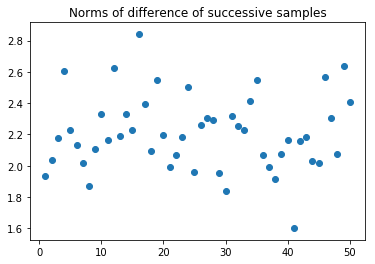

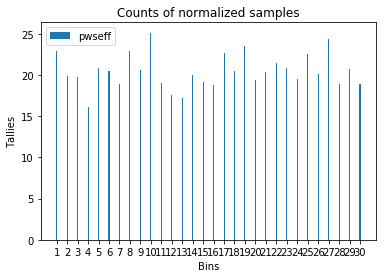

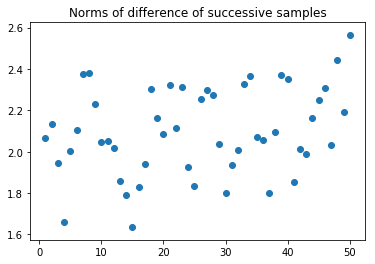

In [14]:
varnames=['pwsi','soeci','pemeci','sofci','pemfci','ccsgi','ccsci','pwsemi','soecemi','pwseff']
for strs in varnames:
    lst1=cbins[strs]
    lst2=diffnorm[strs]
    plotsamples(lst1,lst2,strs)

In [ ]:
#sns.distplot(cbins['pwsi'])
print(np.linspace(0.0,1.0,41))